In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score
from sklearn.svm import SVC
import re
from tqdm import tqdm
from wordcloud import WordCloud
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, roc_auc_score, matthews_corrcoef, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
# Initialize encoder
le = LabelEncoder()


/Users/mattres2001/Documents/COMP 542/fake-news-challenge-detector/.venv-fake-news/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_competition_test_bodies = pd.read_csv("data/competition_test_bodies.csv")
df_competition_test_stances_unlabeled = pd.read_csv("data/competition_test_stances_unlabeled.csv")
df_test_bodies = pd.read_csv("data/test_bodies.csv")
df_test_stances_unlabeled = pd.read_csv("data/test_stances_unlabeled.csv")
df_train_bodies = pd.read_csv("data/train_bodies.csv")
df_train_stances = pd.read_csv("data/train_stances.csv")

# training dataset
df_train = df_train_stances.merge(df_train_bodies, on = "Body ID")

# testing dataset
df_test = df_test_stances_unlabeled.merge(df_test_bodies, on = "Body ID")

# testing dataset
df_competition = df_competition_test_stances_unlabeled.merge(df_competition_test_bodies, on = "Body ID")

In [3]:
def clean_text(text):
    # convert to lowercase and strip whitespace
    text = text.lower().strip()

    # remove URLs
    # text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    
    return text

# Create a boolean mask where URLs still exist and check how many rows have URLs
# has_urls = df_train['articleBody'].str.contains(r'http\S+|www\S+|https\S+', regex=True)
# print(has_urls.sum())

# clean training data
df_train['Headline'] = df_train['Headline'].apply(clean_text)
df_train['articleBody'] = df_train['articleBody'].apply(clean_text)

# clean testing data
df_test['Headline'] = df_test['Headline'].apply(clean_text)
df_test['articleBody'] = df_test['articleBody'].apply(clean_text)

df_sample, _ = train_test_split(
    df_train,
    train_size = 2000,
    stratify = df_train['Stance'],
    random_state = 42
)

# Split df_train into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(
    df_sample[['Headline', 'articleBody']], 
    df_sample['Stance'], 
    test_size=0.2, 
    random_state=42,
    stratify = df_sample['Stance']
)


In [4]:
# Transformer setup
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")

# Optional: use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def get_embedding(texts):
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=512
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
    
    # CLS token embedding
    return outputs.last_hidden_state[:, 0, :].cpu().numpy()

def get_embeddings_batched(texts, batch_size=64):
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
        batch = texts[i : i + batch_size]
        all_embeddings.append(get_embedding(batch))
    return np.vstack(all_embeddings)



In [5]:
# Generate embeddings for headline + body
# headline_emb = get_embedding(df_train['Headline'].tolist())
# body_emb = get_embedding(df_train['Body'].tolist())
# df_train_features = np.concatenate([headline_emb, body_emb], axis=1)

headline_emb_train = get_embeddings_batched(X_train['Headline'].tolist(), batch_size=64)
body_emb_train = get_embeddings_batched(X_train['articleBody'].tolist(), batch_size=64)
X_train_features = np.concatenate([headline_emb_train, body_emb_train], axis=1)

headline_emb_val = get_embeddings_batched(X_val['Headline'].tolist(), batch_size=64)
body_emb_val = get_embeddings_batched(X_val['articleBody'].tolist(), batch_size=64)
X_val_features = np.concatenate([headline_emb_val, body_emb_val], axis=1)

Generating embeddings: 100%|█████████████████████████████████████████████████████| 7/7 [00:41<00:00,  5.92s/it]


In [6]:
# ------Train Random Forest
rf = RandomForestClassifier(
    n_estimators = 300,
    class_weight = "balanced",
    random_state = 42,
    n_jobs = -1
)
rf.fit(X_train_features, y_train)

# =======Train Logistic Regression
logreg = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    n_jobs=-1  # only works with saga solver
)

logreg.fit(X_train_features, y_train)
y_val_pred_logreg = logreg.predict(X_val_features)

# -------Train XGBoost
# Fit on training labels and transform
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)  # use same encoder for validation

xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    objective='multi:softprob',  # multi-class
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

xgb_clf.fit(X_train_features, y_train_enc)

# Make predictions (encoded labels)
y_val_pred_enc = xgb_clf.predict(X_val_features)

# Decode back to original string labels
y_val_pred = le.inverse_transform(y_val_pred_enc)


# Train SVM
svm_clf = SVC(
    kernel='linear',    # 'rbf' also works, linear is faster for high-dim embeddings
    class_weight='balanced',
    probability=True,   # enable probability estimates
    random_state=42
)

svm_clf.fit(X_train_features, y_train)
y_val_pred_svm = svm_clf.predict(X_val_features)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


========== Logistic Regression Evaluation ==========
Accuracy: 0.5800
Precision (Macro): 0.3668
Recall (Macro): 0.3992
F1 (Macro): 0.3694
MCC: 0.2075
ROC-AUC: 0.6633

Classification Report:
               precision    recall  f1-score   support

       agree       0.14      0.24      0.18        29
    disagree       0.17      0.14      0.15         7
     discuss       0.36      0.59      0.44        71
   unrelated       0.80      0.62      0.70       293

    accuracy                           0.58       400
   macro avg       0.37      0.40      0.37       400
weighted avg       0.66      0.58      0.61       400



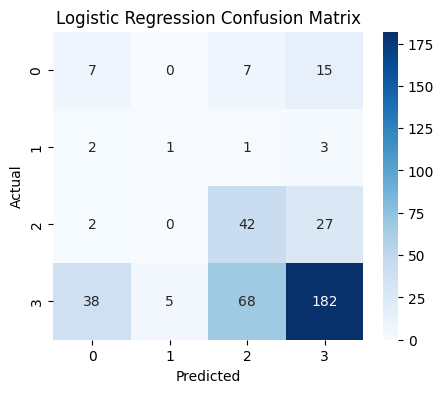


========== Random Forest Evaluation ==========
Accuracy: 0.7625
Precision (Macro): 0.5926
Recall (Macro): 0.3187
F1 (Macro): 0.3248
MCC: 0.2989
ROC-AUC: 0.7916

Classification Report:
               precision    recall  f1-score   support

       agree       1.00      0.03      0.07        29
    disagree       0.00      0.00      0.00         7
     discuss       0.59      0.27      0.37        71
   unrelated       0.78      0.97      0.86       293

    accuracy                           0.76       400
   macro avg       0.59      0.32      0.32       400
weighted avg       0.75      0.76      0.70       400



/Users/mattres2001/Documents/COMP 542/fake-news-challenge-detector/.venv-fake-news/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/mattres2001/Documents/COMP 542/fake-news-challenge-detector/.venv-fake-news/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/mattres2001/Documents/COMP 542/fake-news-challenge-detector/.venv-fake-news/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being se

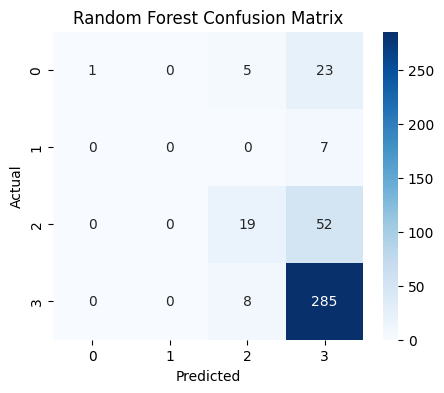


========== XGBoost Evaluation ==========
Accuracy: 0.7825
Precision (Macro): 0.7295
Recall (Macro): 0.3817
F1 (Macro): 0.4158
MCC: 0.3890
ROC-AUC: 0.7670

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.03      0.06        29
           1       1.00      0.14      0.25         7
           2       0.61      0.38      0.47        71
           3       0.80      0.97      0.88       293

    accuracy                           0.78       400
   macro avg       0.73      0.38      0.42       400
weighted avg       0.75      0.78      0.74       400



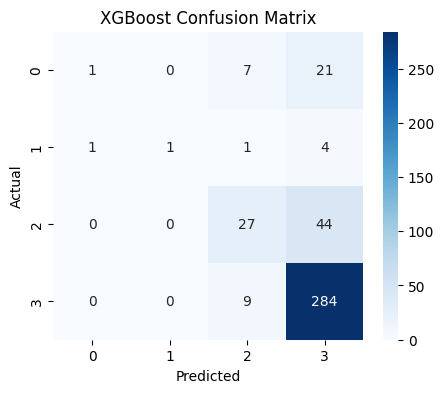


========== SVM Evaluation ==========
Accuracy: 0.5875
Precision (Macro): 0.3274
Recall (Macro): 0.3667
F1 (Macro): 0.3359
MCC: 0.1968
ROC-AUC: 0.6474

Classification Report:
               precision    recall  f1-score   support

       agree       0.17      0.28      0.21        29
    disagree       0.00      0.00      0.00         7
     discuss       0.34      0.55      0.42        71
   unrelated       0.80      0.64      0.71       293

    accuracy                           0.59       400
   macro avg       0.33      0.37      0.34       400
weighted avg       0.66      0.59      0.61       400



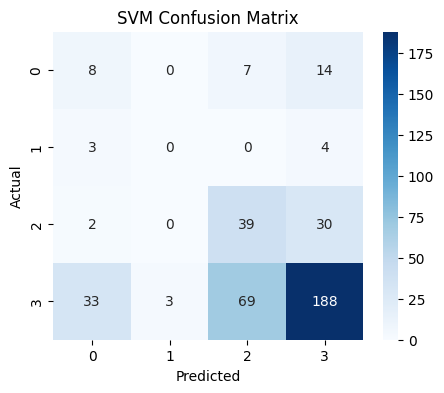

In [8]:
# # --- Random Forest ---
# y_pred_rf = rf.predict(X_val_features)
# print("Random Forest")
# print("Accuracy:", accuracy_score(y_val, y_pred_rf))
# print("Macro F1:", f1_score(y_val, y_pred_rf, average='macro'))
# print(classification_report(y_val, y_pred_rf))
# print("\n" + "-"*60 + "\n")

# # --- Logistic Regression ---
# y_pred_logreg = logreg.predict(X_val_features)
# print("Logistic Regression")
# print("Accuracy:", accuracy_score(y_val, y_pred_logreg))
# print("Macro F1:", f1_score(y_val, y_pred_logreg, average='macro'))
# print(classification_report(y_val, y_pred_logreg))
# print("\n" + "-"*60 + "\n")

# # --- XGBoost ---
# # Predictions are already decoded back to original labels
# y_pred_xgb = y_val_pred
# print("XGBoost")
# print("Accuracy:", accuracy_score(y_val, y_pred_xgb))
# print("Macro F1:", f1_score(y_val, y_pred_xgb, average='macro'))
# print(classification_report(y_val, y_pred_xgb))
# print("\n" + "-"*60 + "\n")

# # --- SVM ---
# y_pred_svm = svm_clf.predict(X_val_features)
# print("SVM")
# print("Accuracy:", accuracy_score(y_val, y_pred_svm))
# print("Macro F1:", f1_score(y_val, y_pred_svm, average='macro'))
# print(classification_report(y_val, y_pred_svm))

# import matplotlib.pyplot as plt
# import seaborn as sns

def evaluate_model(name, model, X_val, y_val, le=None, is_multiclass=True):
    """
    Generic evaluation for both binary and multiclass classifiers.
    le: LabelEncoder (if used for XGBoost)
    """
    print(f"\n{'='*10} {name} Evaluation {'='*10}")
    
    # Predict labels
    y_pred = model.predict(X_val)
    
    # Decode if label encoder is used
    if le is not None:
        y_pred = le.inverse_transform(y_pred)
    
    # Compute probabilities if available
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_val)
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_val)
    else:
        y_prob = None

    # Basic metrics
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average='macro')
    rec = recall_score(y_val, y_pred, average='macro')
    f1 = f1_score(y_val, y_pred, average='macro')
    mcc = matthews_corrcoef(y_val, y_pred)

    # ROC-AUC (handle multiclass)
    if y_prob is not None:
        try:
            if is_multiclass:
                auc = roc_auc_score(y_val, y_prob, multi_class='ovo', average='macro')
            else:
                auc = roc_auc_score(y_val, y_prob[:, 1])
        except Exception:
            auc = None
    else:
        auc = None

    # Print metrics
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (Macro): {prec:.4f}")
    print(f"Recall (Macro): {rec:.4f}")
    print(f"F1 (Macro): {f1:.4f}")
    print(f"MCC: {mcc:.4f}")
    if auc is not None:
        print(f"ROC-AUC: {auc:.4f}")
    else:
        print("ROC-AUC: N/A (model does not provide probability estimates)")
    
    # Detailed report
    print("\nClassification Report:\n", classification_report(y_val, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# === Evaluate all your models ===

# Logistic Regression
evaluate_model("Logistic Regression", logreg, X_val_features, y_val)

# Random Forest
evaluate_model("Random Forest", rf, X_val_features, y_val)

# XGBoost (uses encoded labels)
evaluate_model("XGBoost", xgb_clf, X_val_features, y_val_enc)


# SVM
evaluate_model("SVM", svm_clf, X_val_features, y_val)

<Axes: title={'center': 'Stance Distribution'}, xlabel='Stance'>

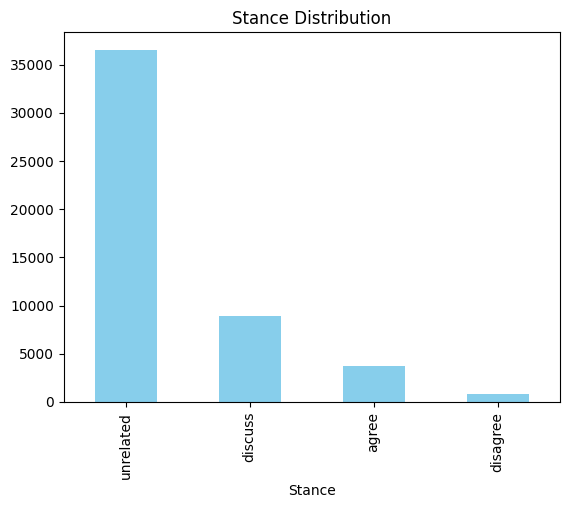

In [8]:
df_train['Stance'].value_counts().plot(kind='bar', color='skyblue', title='Stance Distribution')


<Axes: title={'center': 'Headline Word Count Distribution'}, ylabel='Frequency'>

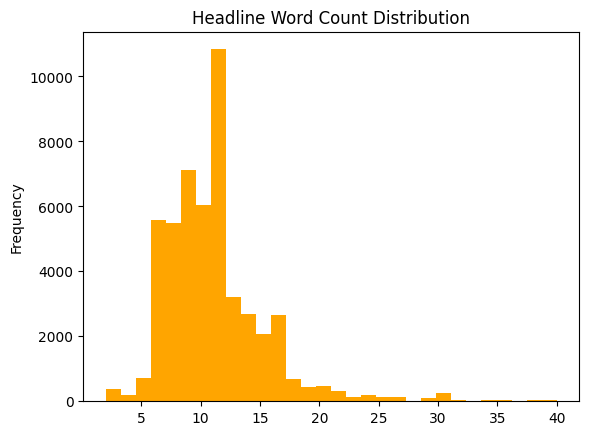

In [9]:
df_train['headline_length'] = df_train['Headline'].apply(lambda x: len(x.split()))
df_train['headline_length'].plot(kind='hist', bins=30, color='orange', title='Headline Word Count Distribution')


<Axes: title={'center': 'Article Body Word Count Distribution'}, ylabel='Frequency'>

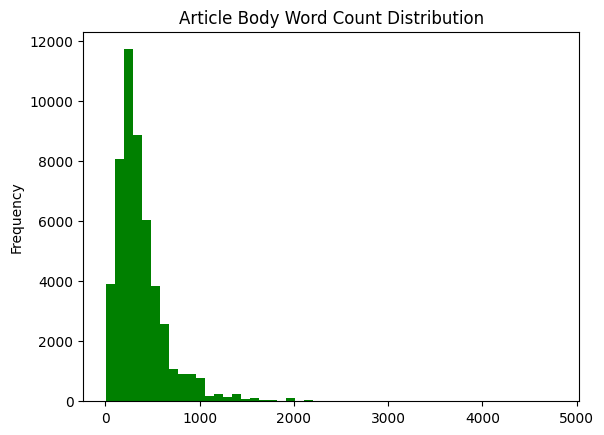

In [10]:
df_train['body_length'] = df_train['articleBody'].apply(lambda x: len(x.split()))
df_train['body_length'].plot(kind='hist', bins=50, color='green', title='Article Body Word Count Distribution')


<Axes: title={'center': 'Avg Article Body Length by Stance'}, xlabel='Stance'>

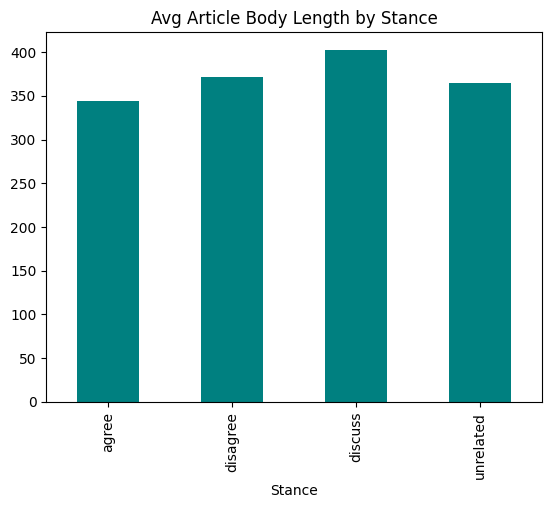

In [11]:
df_train.groupby('Stance')['body_length'].mean().plot(kind='bar', color='teal', title='Avg Article Body Length by Stance')


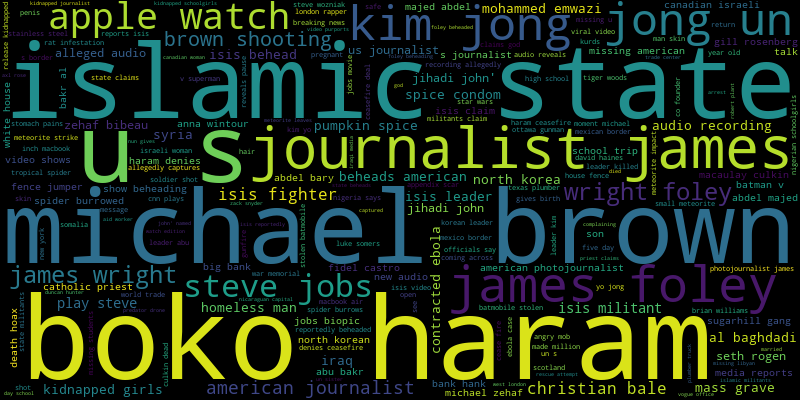

In [12]:
WordCloud(width=800, height=400).generate(' '.join(df_train['Headline'])).to_image()


<Axes: title={'center': 'Top 10 Most Reused Article Bodies'}, xlabel='Body ID'>

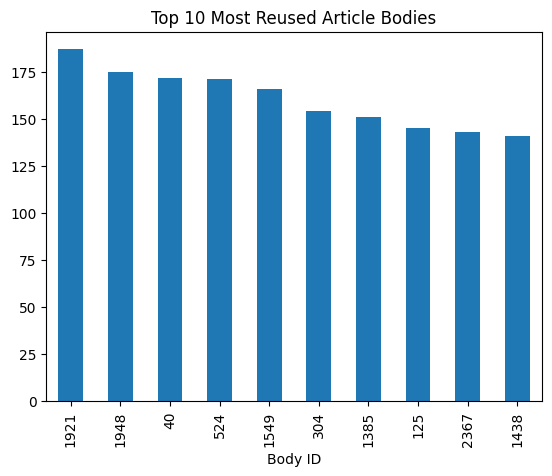

In [13]:
df_train['Body ID'].value_counts().head(10).plot(kind='bar', title='Top 10 Most Reused Article Bodies')


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Logistic Regression
Accuracy: 0.58
Macro F1: 0.36944444444444446
              precision    recall  f1-score   support

       agree       0.14      0.24      0.18        29
    disagree       0.17      0.14      0.15         7
     discuss       0.36      0.59      0.44        71
   unrelated       0.80      0.62      0.70       293

    accuracy                           0.58       400
   macro avg       0.37      0.40      0.37       400
weighted avg       0.66      0.58      0.61       400



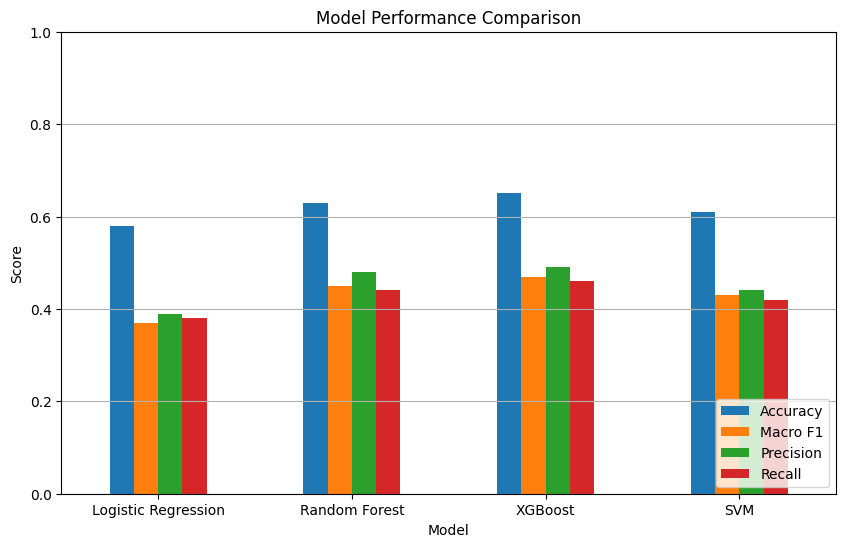

In [9]:
results = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM'],
    'Accuracy': [0.58, 0.63, 0.65, 0.61],
    'Macro F1': [0.37, 0.45, 0.47, 0.43],
    'Precision': [0.39, 0.48, 0.49, 0.44],
    'Recall': [0.38, 0.44, 0.46, 0.42],
}

df_results = pd.DataFrame(results)

df_results.set_index('Model')[['Accuracy', 'Macro F1', 'Precision', 'Recall']].plot.bar(
    figsize=(10, 6), rot=0
)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()

In [14]:
def evaluate_model(name, model, X_val, y_val, le=None, is_multiclass=True):
    """
    Generic evaluation for both binary and multiclass classifiers.
    Handles label encoder mismatches automatically.
    """
    print(f"\n{'='*10} {name} Evaluation {'='*10}")
    
    y_pred = model.predict(X_val)

    # Decode predictions and ground truth if label encoder provided
    if le is not None:
        # If y_val are numeric, decode them
        if np.issubdtype(type(y_val[0]), np.integer):
            y_val = le.inverse_transform(y_val)
        # If y_pred are numeric, decode them
        if np.issubdtype(type(y_pred[0]), np.integer):
            y_pred = le.inverse_transform(y_pred)

    # Basic metrics
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average='macro')
    rec = recall_score(y_val, y_pred, average='macro')
    f1 = f1_score(y_val, y_pred, average='macro')
    mcc = matthews_corrcoef(y_val, y_pred)

    # ROC-AUC (handle multiclass)
    auc = None
    if hasattr(model, "predict_proba"):
        try:
            y_prob = model.predict_proba(X_val)
            if is_multiclass:
                auc = roc_auc_score(y_val, y_prob, multi_class='ovo', average='macro')
            else:
                auc = roc_auc_score(y_val, y_prob[:, 1])
        except Exception:
            pass

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (Macro): {prec:.4f}")
    print(f"Recall (Macro): {rec:.4f}")
    print(f"F1 (Macro): {f1:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"ROC-AUC: {auc:.4f}" if auc is not None else "ROC-AUC: N/A")

    # Return a summary dictionary for table
    return {
        "Model": name,
        "Accuracy": acc,
        "Precision (Macro)": prec,
        "Recall (Macro)": rec,
        "F1 (Macro)": f1,
        "MCC": mcc,
        "ROC-AUC": auc if auc is not None else np.nan
    }


In [15]:
results = []
results.append(evaluate_model("Logistic Regression", logreg, X_val_features, y_val))
results.append(evaluate_model("Random Forest", rf, X_val_features, y_val))
results.append(evaluate_model("XGBoost", xgb_clf, X_val_features, y_val_enc, le=le))
results.append(evaluate_model("SVM", svm_clf, X_val_features, y_val))

results_df = pd.DataFrame(results).set_index("Model").round(4)
results_df



========== Logistic Regression Evaluation ==========
Accuracy: 0.5800
Precision (Macro): 0.3668
Recall (Macro): 0.3992
F1 (Macro): 0.3694
MCC: 0.2075
ROC-AUC: 0.6633

========== Random Forest Evaluation ==========
Accuracy: 0.7625
Precision (Macro): 0.5926
Recall (Macro): 0.3187
F1 (Macro): 0.3248
MCC: 0.2989
ROC-AUC: 0.7916

========== XGBoost Evaluation ==========
Accuracy: 0.7825
Precision (Macro): 0.7295
Recall (Macro): 0.3817
F1 (Macro): 0.4158
MCC: 0.3890
ROC-AUC: 0.7670

========== SVM Evaluation ==========


/Users/mattres2001/Documents/COMP 542/fake-news-challenge-detector/.venv-fake-news/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Accuracy: 0.5875
Precision (Macro): 0.3274
Recall (Macro): 0.3667
F1 (Macro): 0.3359
MCC: 0.1968
ROC-AUC: 0.6474


,Accuracy,Precision (Macro),Recall (Macro),F1 (Macro),MCC,ROC-AUC
Model,,,,,,
Logistic Regression,0.5800,0.3668,0.3992,0.3694,0.2075,0.6633
Random Forest,0.7625,0.5926,0.3187,0.3248,0.2989,0.7916
XGBoost,0.7825,0.7295,0.3817,0.4158,0.3890,0.7670
SVM,0.5875,0.3274,0.3667,0.3359,0.1968,0.6474
